Contents
1) Prepare Problem
Load libraries

Load and explore the shape of the dataset

2) Summarize Data
Descriptive statistics

Data visualization
3) Prepare Data
Data Cleaning

Split-out validation dataset

Data transformation

4) Evaluate Algorithms
Dimensionality reduction

Compare Algorithms
5) Improve Accuracy
Algorithm Tuning
6) Diagnose the performance of the best algorithms
Diagnose overfitting by plotting the learning and validation curves
Further tuning
7) Finalize Model
Create standalone model on entire training dataset

Predictions on test dataset

In [1]:
#Let us first begin by loading the libraries that we'll use in the notebook
import numpy as np  # linear algebra
import pandas as pd  # read and wrangle dataframes
import matplotlib.pyplot as plt # visualization
import seaborn as sns # statistical visualizations and aesthetics
from sklearn.base import TransformerMixin # To create new classes for transformations
from sklearn.preprocessing import (FunctionTransformer, StandardScaler) # preprocessing 
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import boxcox # data transform
from sklearn.model_selection import (train_test_split, KFold , StratifiedKFold, 
                                     cross_val_score, GridSearchCV, 
                                     learning_curve, validation_curve) # model selection modules
from sklearn.pipeline import Pipeline # streaming pipelines
from sklearn.base import BaseEstimator, TransformerMixin # To create a box-cox transformation class
from collections import Counter
import warnings
# load models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import (XGBClassifier, plot_importance)
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from time import time

%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
#Loading and exploring the shape of the dataset
df = pd.read_csv('glass.csv')
features = df.columns[:-1].tolist()
print(df.shape)

(214, 10)


The dataset consists of 214 observations

In [3]:
df.head(15)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
5,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
6,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
7,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
8,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
9,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [4]:
df.dtypes

RI      float64
Na      float64
Mg      float64
Al      float64
Si      float64
K       float64
Ca      float64
Ba      float64
Fe      float64
Type      int64
dtype: object

In [5]:
#Let's first summarize the distribution of the numerical variables.
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


The features are not on the same scale. For example Si has a mean of 72.65 while Fe has a mean value of 0.057. Features should be on the same scale for algorithms such as logistic regression (gradient descent) to converge smoothly. Let's go ahead and check the distribution of the glass types.

In [6]:
df['Type'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

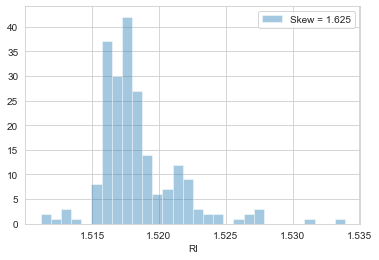

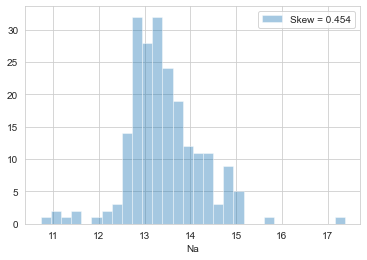

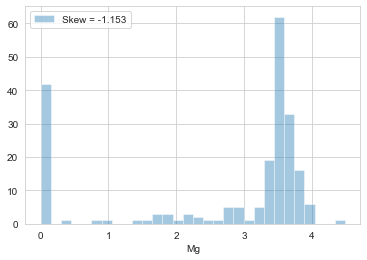

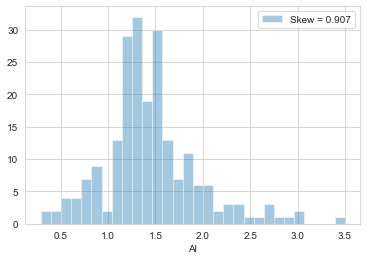

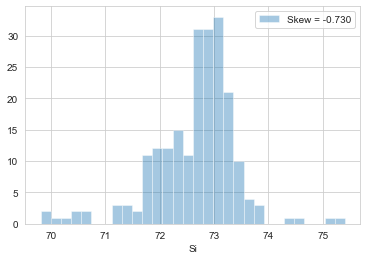

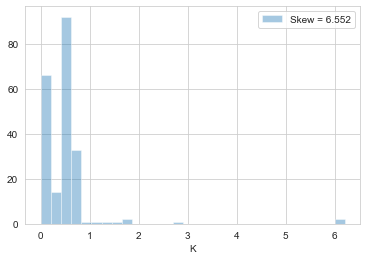

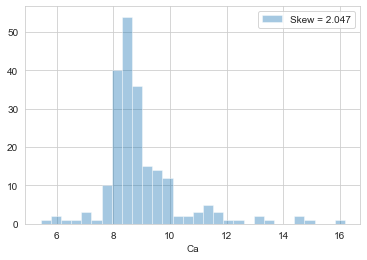

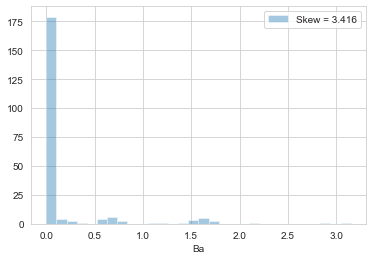

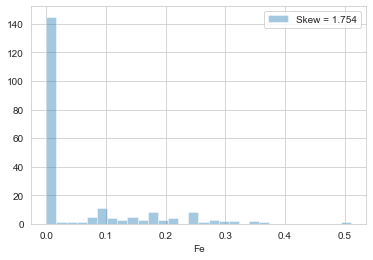

In [7]:
#Let's go ahead an look at the distribution of the different features of this dataset.

for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [8]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[features]))))   

The dataset contains 14 observations with more than 2 outliers


<Figure size 576x576 with 0 Axes>

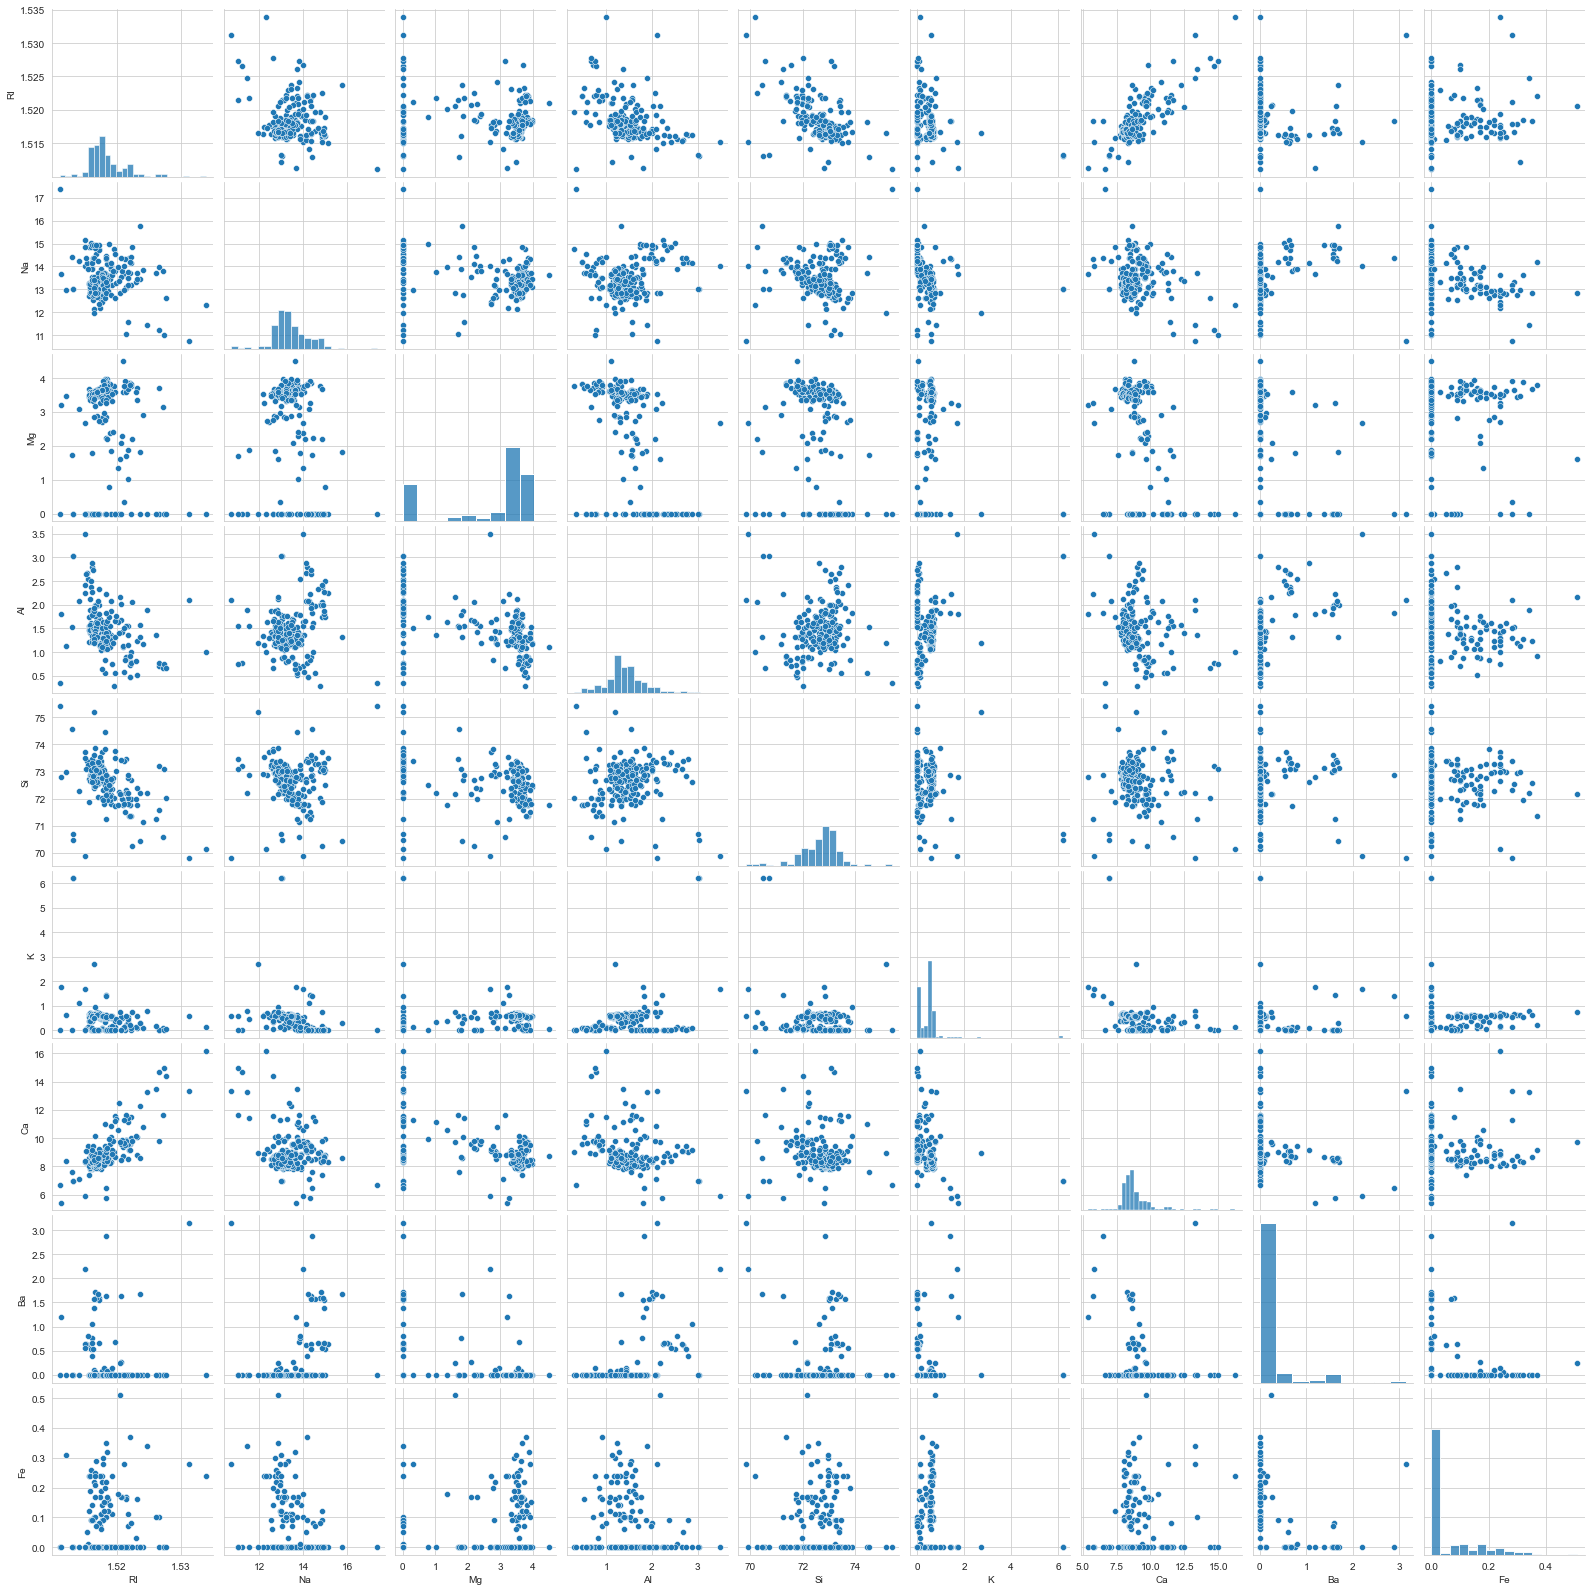

In [11]:
#Multivariate plots
#Let's now proceed by drawing a pairplot to visually examine the correlation between the features.

plt.figure(figsize=(8,8))
sns.pairplot(df[features],palette='coolwarm')
plt.show()

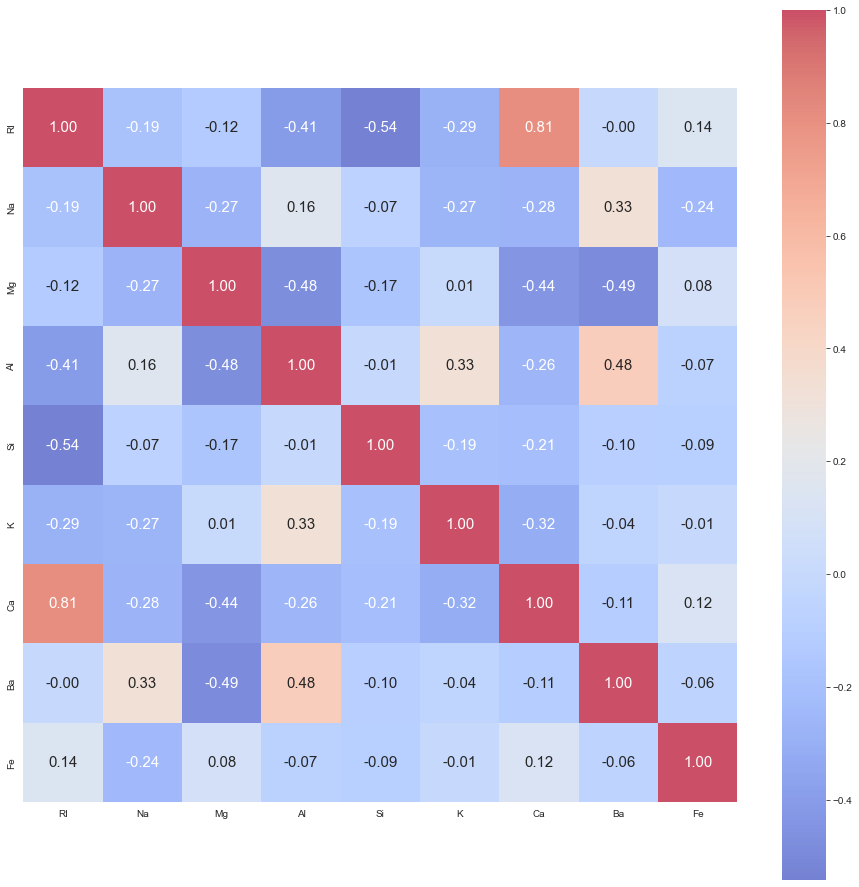

In [12]:
#Let's go ahead and examine a heatmap of the correlations.

corr = df[features].corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features, alpha = 0.7,   cmap= 'coolwarm')
plt.show()

There seems to be a strong positive correlation between RI and Ca. This could be a hint to perform Principal component analysis in order to decorrelate some of the input features.

In [13]:
#Data cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


This dataset is clean; there aren't any missing values in it.

In [14]:
#Hunting and removing multiple outliers
#Let's remove the observations containing multiple outliers with the function we created in the previous section.
outlier_indices = outlier_hunt(df[features])
df = df.drop(outlier_indices).reset_index(drop=True)
print(df.shape)

(200, 10)


Removing observations with multiple outliers (more than 2) leaves us with 200 observations to learn from. Let's now see how our distributions look like.

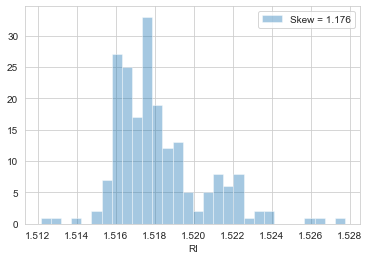

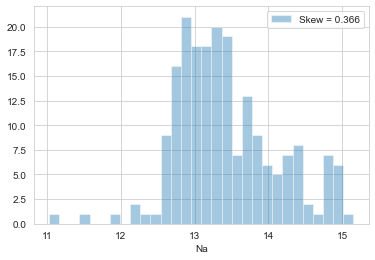

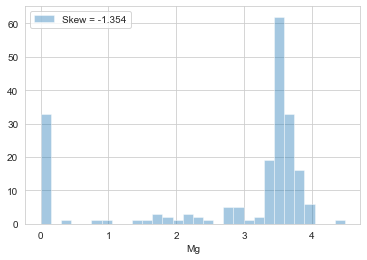

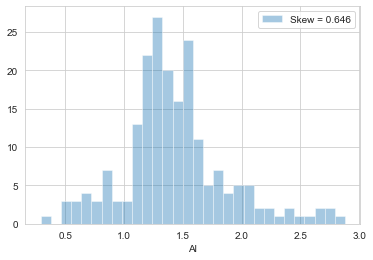

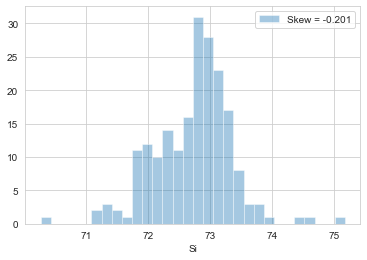

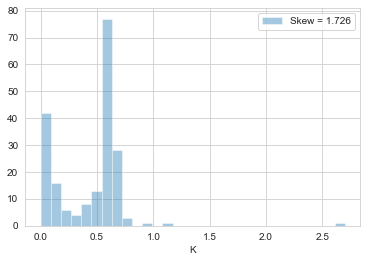

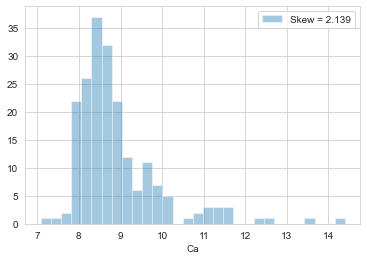

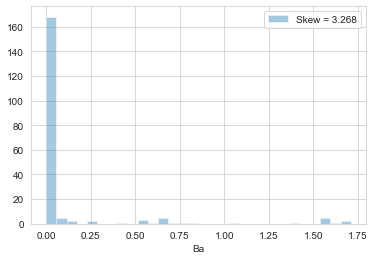

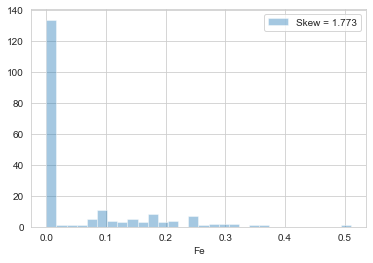

In [15]:
for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde=False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [16]:
df['Type'].value_counts()

1    70
2    70
7    25
3    17
5    10
6     8
Name: Type, dtype: int64

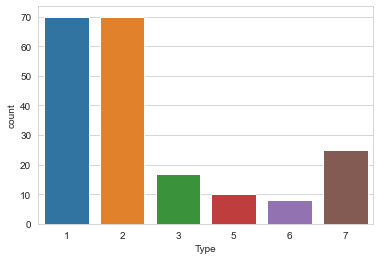

In [17]:
#Let's now plot a distribution of the Types.

sns.countplot(df['Type'])
plt.show()

In [18]:
# Split-out validation dataset
# Define X as features and y as lablels
X = df[features] 
y = df['Type'] 
# set a seed and a test size for splitting the dataset 
seed = 7
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size , random_state = seed)

In [19]:
# Data transformation
# Let's examine if a Box-Cox transform can contribute to the normalization of some features. It should be emphasized that all transformations should only be done on the training set to avoid data snooping. Otherwise the test error estimation will be biased.

features_boxcox = []

for feature in features:
    bc_transformed, _ = boxcox(df[feature]+1)  # shift by 1 to avoid computing log of negative values
    features_boxcox.append(bc_transformed)

features_boxcox = np.column_stack(features_boxcox)
df_bc = pd.DataFrame(data=features_boxcox, columns=features)
df_bc['Type'] = df['Type']

In [20]:
df_bc.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,2.000000e+02,200.000000,200.000000,200.000000,2.000000e+02,200.000000,2.000000e+02,200.000000,200.000000,200.000000
mean,6.159461e-04,0.910643,14.813501,0.955244,6.067071e+09,0.342872,1.999249e-01,0.013377,0.019141,2.670000
std,9.782306e-19,0.003076,8.011923,0.217702,2.873472e+08,0.213507,8.577972e-07,0.031188,0.027757,2.054802
min,6.159461e-04,0.897962,0.000000,0.261374,5.004587e+09,0.000000,1.999215e-01,0.000000,0.000000,1.000000
25%,6.159461e-04,0.908540,10.569803,0.850076,5.893126e+09,0.122922,1.999244e-01,0.000000,0.000000,1.000000
50%,6.159461e-04,0.910269,18.555034,0.938477,6.106954e+09,0.447403,1.999248e-01,0.000000,0.000000,2.000000
75%,6.159461e-04,0.912445,19.835863,1.060851,6.238759e+09,0.480536,1.999254e-01,0.000000,0.051652,3.000000
max,6.159461e-04,0.917711,31.408319,1.561947,7.293074e+09,1.392148,1.999270e-01,0.091142,0.068796,7.000000


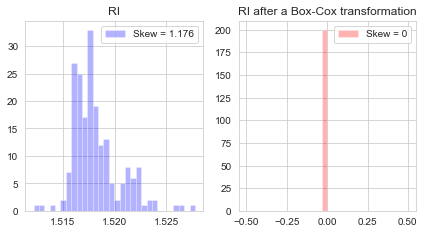

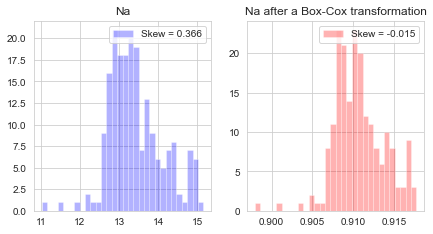

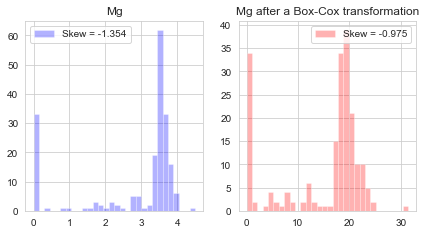

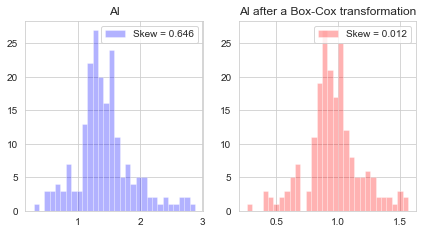

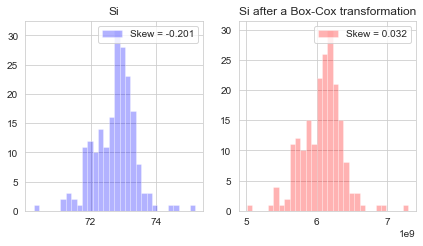

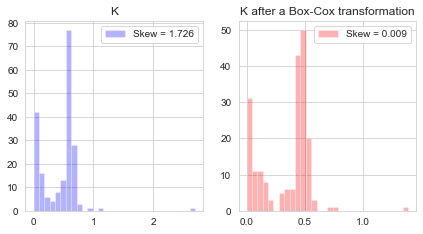

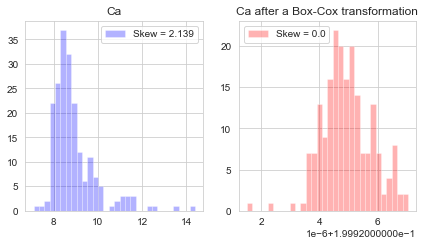

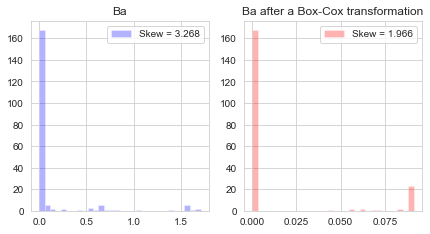

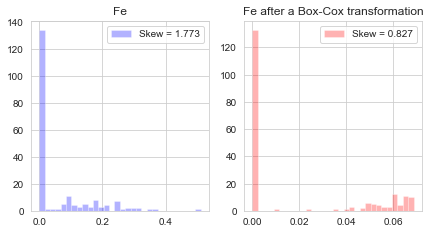

In [29]:
for feature in features:
    fig, ax = plt.subplots(1,2,figsize=(7,3.5))    
    ax[0].hist(df[feature], color='blue', bins=30, alpha=0.3, label='Skew = %s' %(str(round(df[feature].skew(),3))) )
    ax[0].set_title(str(feature))   
    ax[0].legend(loc=0)
    ax[1].hist(df_bc[feature], color='red', bins=30, alpha=0.3, label='Skew = %s' %(str(round(df_bc[feature].skew(),3))) )
    ax[1].set_title(str(feature)+' after a Box-Cox transformation')
    ax[1].legend(loc=0)
    plt.show()

In [30]:
# check if skew is closer to zero after a box-cox transform
for feature in features:
    delta = np.abs( df_bc[feature].skew() / df[feature].skew() )
    if delta < 1.0 :
        print('Feature %s is less skewed after a Box-Cox transform' %(feature))
    else:
        print('Feature %s is more skewed after a Box-Cox transform'  %(feature))

Feature RI is less skewed after a Box-Cox transform
Feature Na is less skewed after a Box-Cox transform
Feature Mg is less skewed after a Box-Cox transform
Feature Al is less skewed after a Box-Cox transform
Feature Si is less skewed after a Box-Cox transform
Feature K is less skewed after a Box-Cox transform
Feature Ca is less skewed after a Box-Cox transform
Feature Ba is less skewed after a Box-Cox transform
Feature Fe is less skewed after a Box-Cox transform


In [37]:
#TRAIN TEST SPLIT
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0,stratify=y)
## Flattening the array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
print('Shape of X_train = ' + str(X_train.shape))
print('Shape of X_test = ' + str(X_test.shape))
print('Shape of y_train = ' + str(y_train.shape))
print('Shape of y_test = ' + str(y_test.shape))

Shape of X_train = (150, 9)
Shape of X_test = (50, 9)
Shape of y_train = (150,)
Shape of y_test = (50,)


In [38]:
#KNN
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

Scores = []

for i in range (2,11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    score = knn.score(X_test,y_test)
    Scores.append(score)

print(knn.score(X_train,y_train))
print(Scores)

0.6933333333333334
[0.72, 0.62, 0.72, 0.72, 0.7, 0.64, 0.6, 0.66, 0.68]


In [39]:
#DECISION TREE
from sklearn.tree import DecisionTreeClassifier

Scores = []

for i in range(1):
    tree = DecisionTreeClassifier(random_state=0)
    tree.fit(X_train, y_train)
    score = tree.score(X_test,y_test)
    Scores.append(score)

print(tree.score(X_train,y_train))
print(Scores)

1.0
[0.52]


In [40]:
#LOGISTIC REGRESSION---------------
from sklearn.linear_model import LogisticRegression

Scores = []

for i in range(1):
    logistic = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',max_iter=100)
    logistic.fit(X_train, y_train)
    score = logistic.score(X_test,y_test)
    Scores.append(score)
    
print(logistic.score(X_train,y_train))
print(Scores)

0.6533333333333333
[0.66]


In [41]:
#SVC--------------
from sklearn.svm import SVC

Scores = []

for i in range(1):
    svc = SVC(gamma='auto')
    svc.fit(X_train, y_train)
    score = svc.score(X_test,y_test)
    Scores.append(score)

print(svc.score(X_train,y_train))
print(Scores)

0.7133333333333334
[0.68]


In [42]:
#RANDOM FOREST----
from sklearn.ensemble import RandomForestClassifier

Scores = []
Range = [10,20,30,50,70,80,100,120]

for i in range(1):
    forest = RandomForestClassifier(criterion='gini', n_estimators=10, min_samples_leaf=1, min_samples_split=4, random_state=1,n_jobs=-1)
    #forest = RandomForestClassifier(n_estimators=i ,random_state=0)
    forest.fit(X_train, y_train)
    score = forest.score(X_test,y_test)
    #Scores.append(score)

print(forest.score(X_train,y_train))
print(score)

0.98
0.78


In [43]:
#Gradient Decent Tree Boosting-------
from sklearn.ensemble import GradientBoostingClassifier

gd = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

gd.fit(X_train, y_train)
score = gd.score(X_test,y_test)

print(gd.score(X_train,y_train))
print(score)

1.0
0.68


THUS, Randorm forest is giving best result with:

training accuracy: 0.98
test accuracy: 0.78